# Activity 13.01 - Creating a time series model

In this activity, as a data analyst for a bike-share starup, you are provided witha  dataset that has hourly unit rentals for a bike-share business. You are tasked to create a very simple model to predict the rentals one week in advance

1. For this activity, you will need the pandas library, the matplotlib.pyplot library, and the sklearn.linear_model.LinearRegression module. Load them in the first cell of the  notebook. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

2. Read in the bike_share.csv data from the Datasets directory, and list the first few rows:

In [2]:
df=pd.read_csv('Chapter13-Datasets/bike_share.csv')
df.head()

,date,hour,rentals
0,1/1/2011,0,16
1,1/1/2011,1,40
2,1/1/2011,2,32
3,1/1/2011,3,13
4,1/1/2011,4,1


3. You need to create a datetime index. Construct a new datetime-valued column as a combination of the date and the hour and make it the index:

In [3]:
df['date_time']=[(df.date[i] +' '+'{:02}'.format(df.hour[i])+':00:00') for i in df.index]
df.set_index(pd.to_datetime(df['date_time']), inplace=True, drop= True)
df

,date,hour,rentals,date_time
date_time,,,,
2011-01-01 00:00:00,1/1/2011,0,16,1/1/2011 00:00:00
2011-01-01 01:00:00,1/1/2011,1,40,1/1/2011 01:00:00
2011-01-01 02:00:00,1/1/2011,2,32,1/1/2011 02:00:00
2011-01-01 03:00:00,1/1/2011,3,13,1/1/2011 03:00:00
2011-01-01 04:00:00,1/1/2011,4,1,1/1/2011 04:00:00
...,...,...,...,...
2012-12-31 19:00:00,12/31/2012,19,119,12/31/2012 19:00:00
2012-12-31 20:00:00,12/31/2012,20,89,12/31/2012 20:00:00
2012-12-31 21:00:00,12/31/2012,21,90,12/31/2012 21:00:00


4. Generate a simple plot of the data versus time:

<AxesSubplot:xlabel='date_time'>

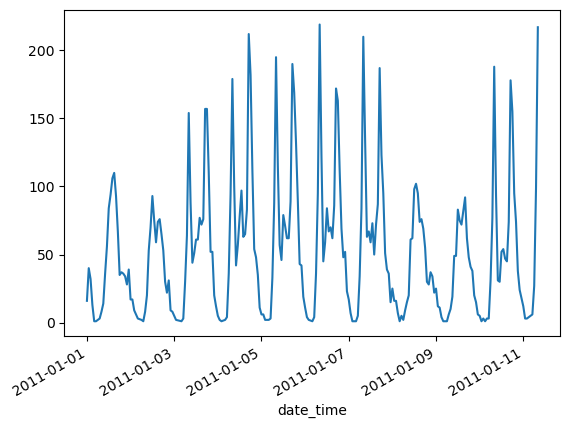

In [4]:
df['rentals'][:240].plot()

5. Using the index and the rentals column, downsample the data to 1-day intervals. You want total rentals per day, so choose the appropriate aggregation function:

In [5]:
df = pd.DataFrame(df['rentals'].resample('1d').sum())
df.head(14)

,rentals
date_time,
2011-01-01,985
2011-01-02,801
2011-01-03,1349
2011-01-04,1562
2011-01-05,1600
2011-01-06,1606
2011-01-07,1510
2011-01-08,959
2011-01-09,822


6. Generate a simple plot of the first 8 weeks (56 days) of the resampled data:

<AxesSubplot:xlabel='date_time'>

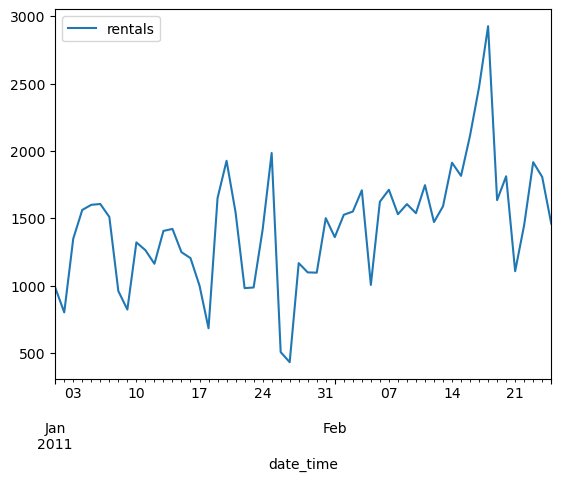

In [6]:
df[:56].plot()

7. You should notice there are ups and downs that seem to be on about a 7-day cycle. Explore this by plotting the data versus itself, shifted appropriately:

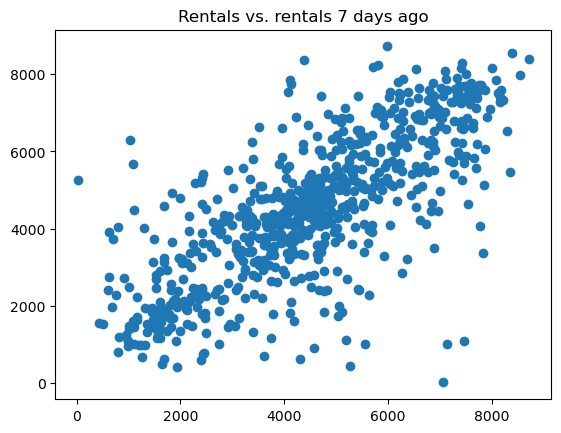

In [7]:
fig, ax = plt.subplots()
ax.scatter(df['rentals'][:(df.shape[0]-7)],df['rentals'][7:])
ax.set_title('Rentals vs. rentals 7 days ago')
plt.show()

8. Preparing to apply linear regression to the data, create a new column with shifted data:

In [8]:
lagged_rentals=df['rentals'][: (df.shape[0]-7)]
lagged_rentals.index = df.index[7:]
df['lagged_rentals']=lagged_rentals
df

,rentals,lagged_rentals
date_time,,
2011-01-01,985,NaN
2011-01-02,801,NaN
2011-01-03,1349,NaN
2011-01-04,1562,NaN
2011-01-05,1600,NaN
...,...,...
2012-12-27,2114,4128.0
2012-12-28,3095,3623.0
2012-12-29,1341,1749.0


9. Now, use the LinearRegression module to fit a linear model, using the lagged data as the X data, and the actual rentals as the Y data.

In [9]:
model_data = df.copy()[df['lagged_rentals'].isna()==False]
lagged_model=LinearRegression()
lagged_model.fit(model_data['lagged_rentals'].values.reshape(-1,1),model_data['rentals'].values.reshape(-1,1))
                 
model_data['predicted']=lagged_model.predict(model_data['lagged_rentals'].values.reshape(-1,1))

R2 = lagged_model.score(model_data['rentals'].values.reshape(-1,1), model_data['predicted'].values.reshape(-1,1))

print('R2 is ', R2, ' using:')
print(model_data[['rentals', 'lagged_rentals']].head())

R2 is  0.5145071365683822  using:
            rentals  lagged_rentals
date_time                          
2011-01-08      959           985.0
2011-01-09      822           801.0
2011-01-10     1321          1349.0
2011-01-11     1263          1562.0
2011-01-12     1162          1600.0


10. Plot the predicted values versus the actual values and compare them to an ideal prediction.

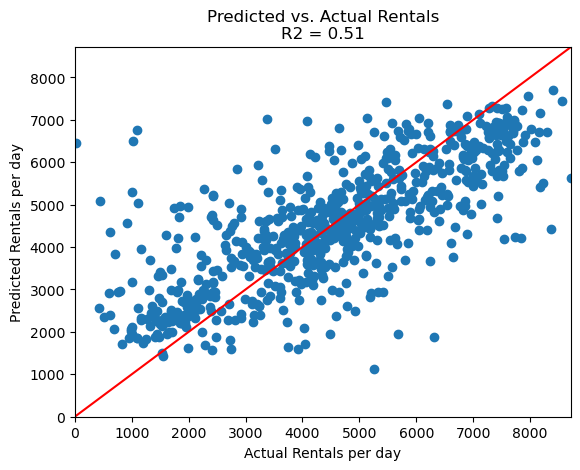

In [10]:
fig, ax = plt.subplots()
ax.scatter(model_data['rentals'],model_data['predicted'])
xlim=(0,max(pd.concat([model_data['predicted'],model_data['rentals']])))
ylim=xlim
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.plot([xlim[0],xlim[1]],
       [ylim[0],ylim[1]],
       color='red')
ax.set_title('Predicted vs. Actual Rentals\n'+ 'R2 = '+str(round(R2,2)))
ax.set_xlabel('Actual Rentals per day')
ax.set_ylabel('Predicted Rentals per day')
plt.show()